### Résolution du problème _Soft Support Vector Machine_ par Descente de Gradient et par Descente de Gradient Stochastique

Voir chapitre 15 du livre Understanding Machine Learning de S. Shalev-Shwartz et S. Ben-David

In [1]:
using Random
using Gadfly
using LinearAlgebra
using DataFrames

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/navaro/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


In [2]:
hinge_loss(x :: Float64 ) = max(0,1-x)

hinge_loss (generic function with 1 method)

In [3]:
mutable struct HyperPlan{d}
    
    w :: Vector{Float64}
    b :: Float64
    
    function HyperPlan{d}() where {d}
        new(zeros(d), 0.0)
    end
    
    function HyperPlan{d}(w :: Vector{Float64}) where {d}
        n = length(w)
        if d >= n
            w = [w;zeros(d-n)]
        else
            w = w[1:d]
        end
        new(w, 0.0)
    end   
    
    function HyperPlan{d}(w :: Vector{Float64}, 
                          b :: Float64) where {d}
        n = length(w)
        d >= n && (w = [w;zeros(d-n)])
        d >= n || (w = w[1:d])
        new(w, b)
    end
end

Base.ndims(::HyperPlan{d}) where {d} = d

In [50]:
function (h :: HyperPlan)( x :: Vector{Float64})
    dot(h.w, x) + h.b
end

In [51]:
import Base:+

function +(h1 :: HyperPlan{d}, h2 :: HyperPlan{d}) where {d}

    HyperPlan{d}(h1.w + h2.w, h1.b + h2.b)

end

+ (generic function with 230 methods)

In [52]:
import Base:-

function -(h1 :: HyperPlan{d}, h2 :: HyperPlan{d}) where {d}

    HyperPlan{d}(h1.w - h2.w, h1.b - h2.b)

end

- (generic function with 230 methods)

In [53]:
function external_prod(h :: HyperPlan{d}, 
                       a :: Float64) where {d} 
    
    HyperPlan{d}(h.w .* a, h.b * a)
    
end

external_prod (generic function with 1 method)

In [54]:
function loss(h :: HyperPlan{d}, 
     x :: Vector{Float64}, 
     y :: Float64) where {d} 
    
    hinge_loss(y * h(x))
end

loss (generic function with 2 methods)

In [55]:
square(h :: HyperPlan) = dot(h.w, h.w) + h.b^2

square (generic function with 1 method)

In [56]:
function risk(h     :: HyperPlan{d}, 
              x     :: Array{Float64, d}, 
              y     :: Array{Float64, 1}, 
              lambd :: Float64) where {d}
    
    (lambd/2 * square(h)
        +1/length(y)*sum([loss(h, x[i,:], y[i]) 
                for i in 1:size(x)[1]]))
end 

risk (generic function with 1 method)

In [57]:
function risk_vrai(h :: HyperPlan{d}, 
                   x :: Array{Float64,d}, 
                   y :: Vector{Float64}) where {d}
    n = length(y)
    @assert n == size(x)[1]
    sum([sign.(h(x[i,:])) != y[i] for i in 1:n])/n
end

risk_vrai (generic function with 1 method)

In [58]:
function gradient_loss(h     :: HyperPlan{d}, 
                       x     :: Vector{Float64}, 
                       y     :: Float64, 
                       lambd :: Float64) where {d}
    if y * h(x) < 1
        v1 = lambd .* h.w .- y .* x
        v2 = lambd * h.b - y
    else
        v1 = lambd .* h.w
        v2 = lambd * h.b
    end
    HyperPlan{d}(v1, v2)
end

gradient_loss (generic function with 1 method)

In [59]:
function gradient_risk(h     :: HyperPlan{d}, 
                       x     :: Array{Float64,d}, 
                       y     :: Vector{Float64}, 
                       lambd :: Float64) where {d}
    grad = HyperPlan{d}()
    n = length(y)
    @assert n == size(x)[1]
    for i in 1:n
        grad = grad + gradient_loss(h, x[i,:], y[i], lambd)
    end
    external_prod(grad, 1/n)
end

gradient_risk (generic function with 1 method)

In [60]:
d = 2
h1, h2 = HyperPlan{d}([1., 2.], 1.), HyperPlan{d}([3., 4.], 2.)
@show h1 + h2
@show square(h1), square(h2)
@show loss(h1, [0.1,0.2], 1.0), loss(h2, [0.1,0.2], -1.0)

h1 + h2 = HyperPlan{2}([4.0, 6.0], 3.0)
(square(h1), square(h2)) = (6.0, 29.0)
(loss(h1, [0.1, 0.2], 1.0), loss(h2, [0.1, 0.2], -1.0)) = (0.0, 4.1)


(0.0, 4.1)

In [63]:
@show risk(h1, [0.1 0.2], [0.5], 1.), risk(h2, [0.1 0.2], [0.5], 1.)

(risk(h1, [0.1 0.2], [0.5], 1.0), risk(h2, [0.1 0.2], [0.5], 1.0)) = (3.25, 14.5)


(3.25, 14.5)

In [65]:
@show risk_vrai(h1, [0.1 0.2], [0.5]), risk_vrai(h2, [0.1 0.2], [0.5])

(risk_vrai(h1, [0.1 0.2], [0.5]), risk_vrai(h2, [0.1 0.2], [0.5])) = (1.0, 1.0)


(1.0, 1.0)

In [71]:
@show gradient_loss(h1, [0.1,0.2], 0.5, 1.)
@show gradient_loss(h2, [0.1,0.2], 0.5, 1.)
@show gradient_risk(h1, [0.1 0.2], [0.5], 1.)
@show gradient_risk(h2, [0.1 0.2], [0.5], 1.)

gradient_loss(h1, [0.1, 0.2], 0.5, 1.0) = HyperPlan{2}([0.95, 1.9], 0.5)
gradient_loss(h2, [0.1, 0.2], 0.5, 1.0) = HyperPlan{2}([3.0, 4.0], 2.0)
gradient_risk(h1, [0.1 0.2], [0.5], 1.0) = HyperPlan{2}([0.95, 1.9], 0.5)
gradient_risk(h2, [0.1 0.2], [0.5], 1.0) = HyperPlan{2}([3.0, 4.0], 2.0)


HyperPlan{2}([3.0, 4.0], 2.0)

In [86]:
function SGD(h     :: HyperPlan{d}, 
             x     :: Array{Float64,2}, 
             y     :: Vector{Float64}, 
             lambd :: Float64,  
             niter     = 1000, 
             learning  = 0.1, 
             averaging = 1) where {d}
    
    i0       = abs(niter-averaging)
    liste    = HyperPlan{d}[h]
    resultat = h
    
    for i in 1:niter
        it = rand(1:size(x)[1])
        vt = gradient_loss(liste[i], x[it,:], y[it], lambd)
        push!(liste,liste[i]-external_prod(liste[i],
                learning/(1+learning*lambd*(i))))
        mut = 1/max(1,i-i0)
        resultat = (external_prod(resultat, 1-mut)
            + external_prod(liste[end], mut))
    end
    resultat,liste
end

SGD (generic function with 4 methods)

In [87]:
function GD(h, x, y, lambd, niter=1000, learning=0.1, averaging=1)
    liste = HyperPlan[h]
    for i in 1:niter
        vt = gradient_risk(liste[i], x, y, lambd)
        push!(liste, 
            liste[i]-external_prod(vt, 
                learning/(1+learning*lambd*(i))))
    end
    liste[end], liste
end

GD (generic function with 4 methods)

In [88]:
using LinearAlgebra

mutable struct Polynomial
    
    weights :: Array{Float64, 2}
    void    :: Array{Float64, 2}

    function Polynomial(w )
        d = size(w)[1]
        void = zeros(Float64, (d,d))
        for i in 1:d
            for j in 1:d-i+1
                void[i,j] = 1
            end
        end
        weights = void .* w
        new( weights, void)
    end
end

degree(p :: Polynomial) = size(p.weights)[1]-1
    
function (p :: Polynomial)( x :: Vector{Float64} )
    @assert length(x) > 1
    X1 = [x[1]^exp for exp in 0:degree(p)]
    X2 = [x[2]^exp for exp in 0:degree(p)]
    ((p.weights * X1)' * X2)[1,1]
end

In [89]:
p1 = Polynomial([1.,-2,3,4])
x = [1.,1]
p1(x)

8.0

In [90]:
[1. -2; 3  4]

2×2 Array{Float64,2}:
 1.0  -2.0
 3.0   4.0

In [91]:
p1 = Polynomial([1. -2; 3  4])
x = [1.,1]
p1(x)

2.0

In [92]:
function affiche(x, y, h :: HyperPlan)
    m = length(y)
    yresult = [sign(h(x[i,:])) for i in 1:m]
    
    p1 = plot( x = x[:,1], y = x[:,2], color=y)
    p2 = plot( x = x[:,1], y = x[:,2], color=yresult)
    
    hstack(p1, p2)
end

affiche (generic function with 1 method)

In [93]:
function affiche_risques(liste, x, y, lambd)
    y1 = [risk(h, x, y, lambd) for h in liste]
    y2 = [risk_vrai(h, x, y) for h in liste]
    df1 = DataFrame( x = collect(1:length(liste)), 
        y = y1, label = :risque)
    df2 = DataFrame( x = collect(1:length(liste)), 
        y = y2, label = :risque_vrai)
    df = vcat(df1,df2)
    plot(df, x=:x, y=:y, Geom.line, 
        color= :label, 
        Scale.color_discrete_manual("blue","red"))
end

affiche_risques (generic function with 1 method)

In [100]:
# Les paramètres :
# dimension de l'espace des x
h = HyperPlan{2}()
# degré du polynôme de départ
deg = 1
# on introduit ce petit pourcentage d'erreurs dans les données
seuil_erreur = 0.
# taille de l'échantillon de données d'entraînement
m=100
# taille de l'échantillon de données de test 
mtest=1000
# bornes sur l'espace des données x
xmax =  1.25
xmin = -1.25
# valeur de lambda pour le soft-SVM
lambd=1.
# valeur du taux d'apprentissage initialement pour le soft-SVM
learning  = 0.1
# taille du stencil pour l'averaging dans la SGD
averaging = 10

10

In [101]:
# fabrication des données
Random.seed!(1234)
w   = rand(Float64,deg+1,deg+1)
w[1,1] = 0.0
w

2×2 Array{Float64,2}:
 0.0       0.566237
 0.766797  0.460085

In [102]:
pf = Polynomial(w)
x  = xmin .+ (xmax .- xmin) .* rand(Float64,(m, ndims(h)))
u  = rand(Float64,m)
y  = zeros(m)
y[ u .>  seuil_erreur ] .=   sign.([pf(x[i,:]) for i in 1:m if u[i] >   seuil_erreur])
y[ u .<= seuil_erreur ] .= - sign.([pf(x[i,:]) for i in 1:m if u[i] <=  seuil_erreur])

0-element view(::Array{Float64,1}, Int64[]) with eltype Float64

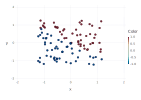

In [103]:
plot(x = x[:,1], y = x[:,2], color = y)

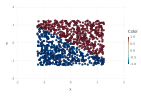

In [104]:
Random.seed!(5678)
xtest = xmin .+ (xmax - xmin) .* rand(Float64,( mtest, ndims(h)))
ytest = sign.([pf(xtest[i,:]) for i in 1:mtest])
plot(x = xtest[:,1], y = xtest[:,2], color = ytest)

In [105]:
# Résolution du problème soft-SVM

h, liste = SGD(h, x, y, lambd, 200, learning, averaging)

(HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}[HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}([0.0, 0.0], 0.0)  …  HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}([0.0, 0.0], 0.0), HyperPlan{2}([0.0, 0.0], 0.0)])

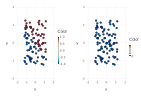

In [106]:
affiche(x, y, h)

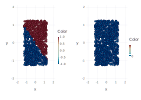

In [107]:
affiche(xtest,ytest,h)

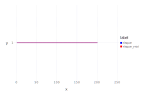

In [108]:
affiche_risques(liste,xtest,ytest,lambd)